In [ ]:
#pip install matplotlib

In [1]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Mute sklearn warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from csv import writer

%matplotlib inline

In [2]:
np.set_printoptions(precision=3, suppress=True)
import tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [3]:
df = pd.read_csv('../data_etl.csv',parse_dates=['Date'],index_col='Date')
xDay = 1
shiftXday = xDay * -1
df['xDay_future_close'] = df['spx_close'].shift(shiftXday)
df['xDay_close_future_pct'] = df['xDay_future_close'].pct_change(xDay)
df['xDay_close_pct'] = df['spx_close'].pct_change(xDay)
df['s5th_close_pct'] = df['s5th_close'].pct_change(xDay)
df['s5fi_close_pct'] = df['s5fi_close'].pct_change(xDay)
feature_names = ['ema_signal','usdjpy_macdsignal','dxy_macdsignal','duj_macdsignal','xDay_close_pct','s5th_close_pct','s5fi_close_pct']

df = df.dropna()
features = df[feature_names]
targets = df['xDay_close_future_pct']
X=features
y=targets
X = X.reset_index()
X = X.drop(columns=['Date'])
y =y.reset_index()
y = y.drop(columns=['Date'])
train_size = int(0.778 * features.shape[0])
train_features = features[:train_size]
train_labels = targets[:train_size]
test_features = features[train_size:]
test_labels = targets[train_size:]

In [4]:
features

,ema_signal,usdjpy_macdsignal,dxy_macdsignal,duj_macdsignal,xDay_close_pct,s5th_close_pct,s5fi_close_pct
Date,,,,,,,
2011-06-20,0.990000,-0.315372,-0.064253,0.002771,0.005395,0.034902,0.192766
2011-06-21,0.991971,-0.312827,-0.049531,0.002929,0.013423,0.067145,0.353935
2011-06-22,0.993003,-0.308445,-0.034030,0.003076,-0.006468,-0.017160,-0.125035
2011-06-23,0.993644,-0.299216,-0.015888,0.003199,-0.002828,-0.011640,-0.104018
2011-06-24,0.993211,-0.286814,0.010221,0.003384,-0.011726,-0.056087,-0.311754
...,...,...,...,...,...,...,...
2021-02-19,1.007958,0.371164,0.040997,-0.002680,-0.001855,-0.013628,-0.037513
2021-02-22,1.006587,0.374501,0.024166,-0.002867,-0.007733,-0.013700,-0.039126
2021-02-23,1.005566,0.372423,0.005685,-0.003025,0.001256,-0.014008,0.012468


In [5]:
axisgrid_features_names = ['xDay_close_future_pct','ema_signal','usdjpy_macdsignal',
                     'dxy_macdsignal','duj_macdsignal','xDay_close_pct',
                     's5th_close_pct','s5fi_close_pct']

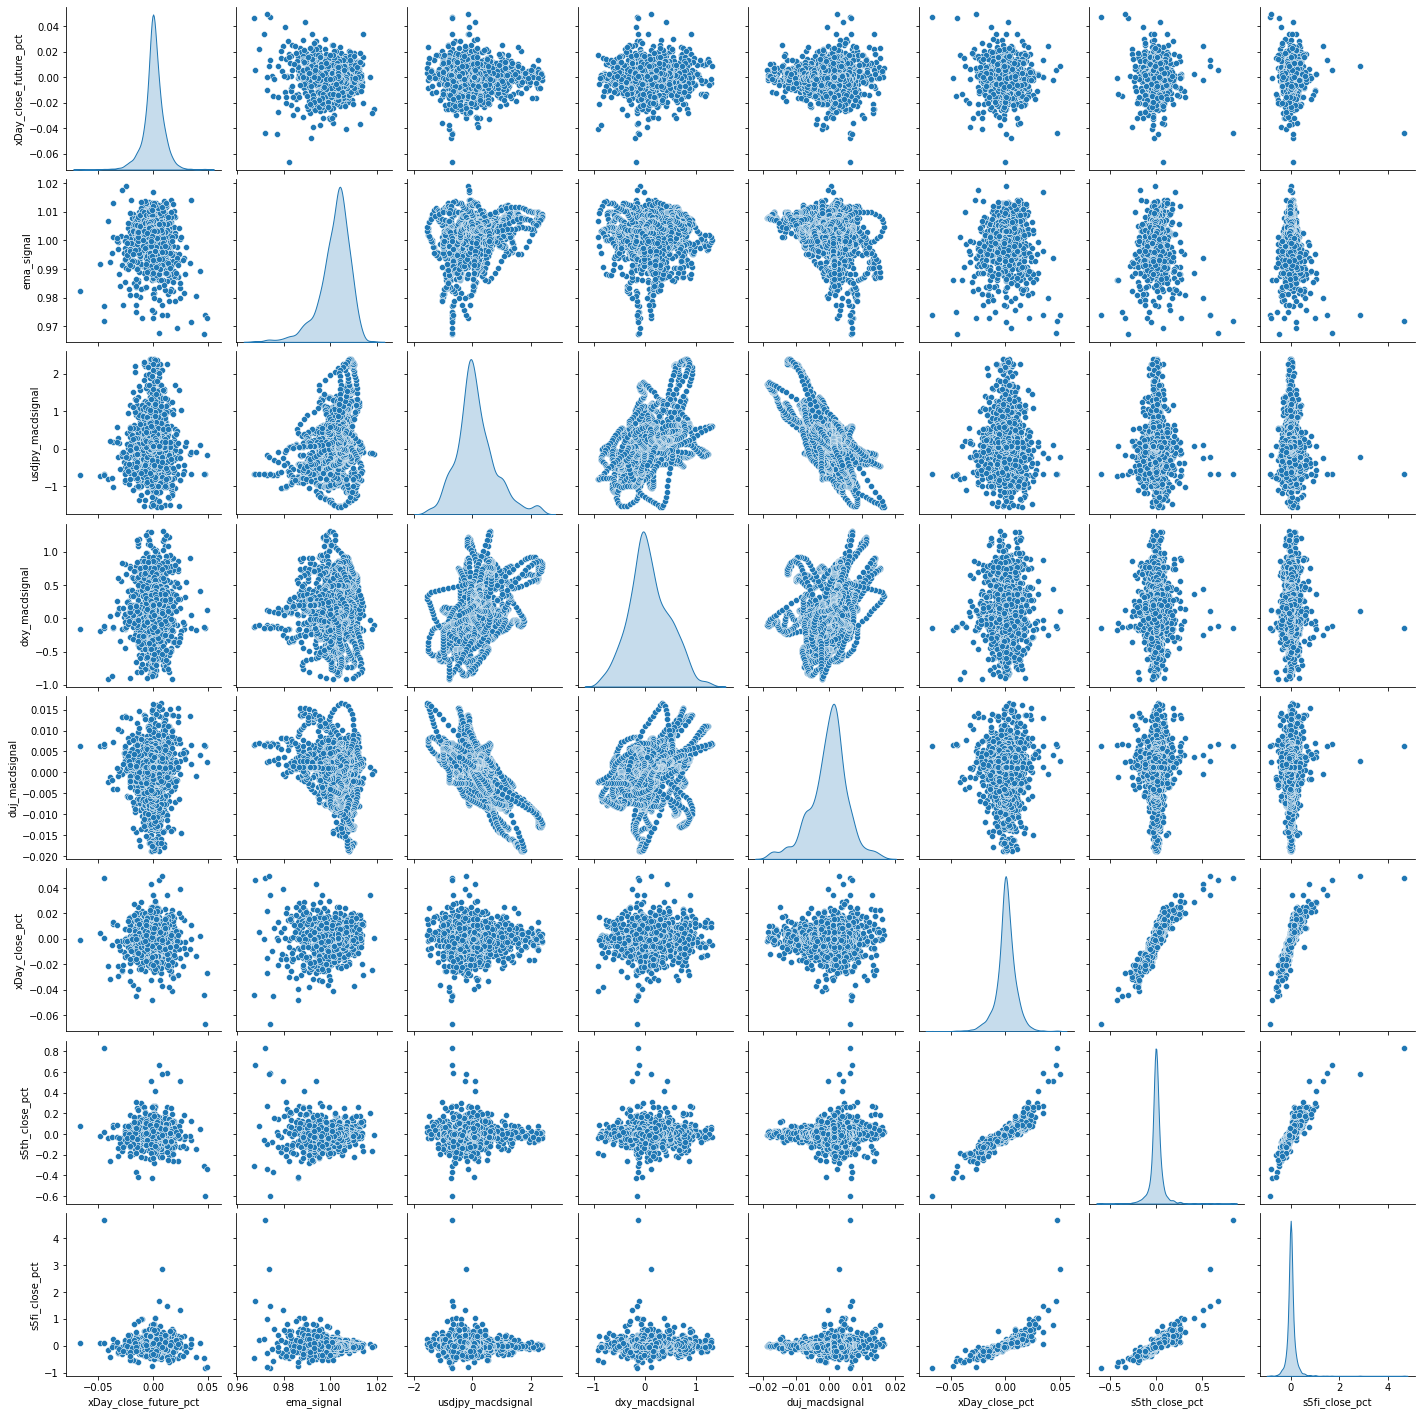

In [6]:
axisgrid_features = df[axisgrid_features_names]
axisgrid_features_train = axisgrid_features[:train_size]
sns.pairplot(axisgrid_features_train[['xDay_close_future_pct','ema_signal','usdjpy_macdsignal',
                     'dxy_macdsignal','duj_macdsignal','xDay_close_pct',
                     's5th_close_pct','s5fi_close_pct']],diag_kind='kde')

In [7]:
axisgrid_features_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
xDay_close_future_pct,1896.0,0.000399,0.009256,-0.066634,-0.003265,0.000476,0.004904,0.049594
ema_signal,1896.0,1.001762,0.006681,0.967138,0.998758,1.003096,1.006032,1.018857
usdjpy_macdsignal,1896.0,0.116964,0.673958,-1.552033,-0.268423,0.019220,0.460828,2.395646
dxy_macdsignal,1896.0,0.081121,0.395254,-0.913493,-0.172146,0.035283,0.347830,1.308731
duj_macdsignal,1896.0,-0.000236,0.005593,-0.018823,-0.003102,0.000442,0.002924,0.016470
xDay_close_pct,1896.0,0.000401,0.009256,-0.066634,-0.003265,0.000476,0.004923,0.049594
s5th_close_pct,1896.0,0.002087,0.073861,-0.601494,-0.019434,0.000000,0.022770,0.833333
s5fi_close_pct,1896.0,0.016622,0.214234,-0.850374,-0.047834,0.000000,0.057931,4.666667


In [8]:
feature_and_target_cols = ['xDay_close_future_pct']+feature_names
feat_targ_df = df[feature_and_target_cols]
corr = feat_targ_df.corr()

In [64]:
#feat_targ_df.to_csv("feat_targ_df.csv")
feat_targ_df

,xDay_close_future_pct,ema_signal,usdjpy_macdsignal,dxy_macdsignal,duj_macdsignal,xDay_close_pct,s5th_close_pct,s5fi_close_pct
Date,,,,,,,,
2011-06-20,0.013423,0.990000,-0.315372,-0.064253,0.002771,0.005395,0.034902,0.192766
2011-06-21,-0.006468,0.991971,-0.312827,-0.049531,0.002929,0.013423,0.067145,0.353935
2011-06-22,-0.002828,0.993003,-0.308445,-0.034030,0.003076,-0.006468,-0.017160,-0.125035
2011-06-23,-0.011726,0.993644,-0.299216,-0.015888,0.003199,-0.002828,-0.011640,-0.104018
2011-06-24,0.009184,0.993211,-0.286814,0.010221,0.003384,-0.011726,-0.056087,-0.311754
...,...,...,...,...,...,...,...,...
2021-02-19,-0.007733,1.007958,0.371164,0.040997,-0.002680,-0.001855,-0.013628,-0.037513
2021-02-22,0.001256,1.006587,0.374501,0.024166,-0.002867,-0.007733,-0.013700,-0.039126
2021-02-23,0.011352,1.005566,0.372423,0.005685,-0.003025,0.001256,-0.014008,0.012468


No handles with labels found to put in legend.


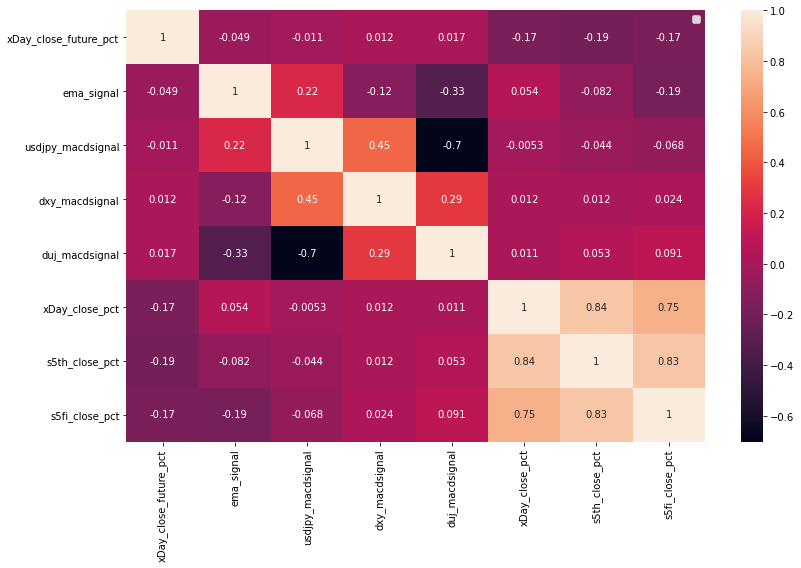

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.legend()
plt.savefig('Heatmap.png',dpi=300)
plt.show()  # show the plot
plt.clf()  # clear the plot area


In [11]:
tensorflow.random.set_seed(445)
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])

#linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

history = linear_model.fit(train_features, train_labels,epochs=100,verbose=0,validation_split = 0.2)

test_linear_preds = linear_model.predict(test_features).flatten()
train_linear_preds = linear_model.predict(train_features).flatten()
train_rmse = np.sqrt(mean_squared_error(train_labels,train_linear_preds))
test_rmse = np.sqrt(mean_squared_error(test_labels,test_linear_preds))
print("Train RMSE: %f" %(train_rmse))
print("Test RMSE: %f" %(test_rmse))
predictions = np.concatenate((train_linear_preds,test_linear_preds),axis=None)
predictions = pd.DataFrame(predictions,columns=['predictions'])
return_data = [df['spx_open'],df['spx_close'],df['xDay_close_future_pct']]
return_header = ["open","close","real_pct"]
df_return = pd.concat(return_data,axis=1,keys=return_header)
df_return = df_return.reset_index()
df_return = pd.concat([df_return,predictions],axis=1)

Train RMSE: 0.041631
Test RMSE: 0.058222


In [12]:
    df_return= df_return.assign(isBuy="")
 
    row = 0

    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1:

            if df_return['predictions'][row]>0:
                df_return['isBuy'][row] = 1
            else:
                df_return['isBuy'][row] = 0
        row = row +1
    df_return = df_return.assign(signal="hold")
    row = 0
    isBought = 0
    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1 and lastRow > -1:
            #print("lastRow:",lastRow,"row:",row)
            if df_return['isBuy'][0]==1:
                df_return['signal'][0] = "buy"
                isBought = 1
            if df_return['isBuy'][row]==1 and df_return['isBuy'][lastRow]==0:
                df_return['signal'][row] = "buy"
                isBought = 1
            if isBought ==1 and df_return['isBuy'][row]==0 and df_return['isBuy'][lastRow]==1:
                df_return['signal'][row] = "sell"
        row = row +1
    df_return= df_return.assign(bsPrice="0")
    row = 0
    for x in df_return['signal']:
        if(row < (df_return.shape[0]-1)):
            tmp = row+1
        if  df_return['signal'][row]== "buy":
          #  df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]

        if df_return['signal'][row] == "sell":
         #   df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]
        row = row +1
    df_return = df_return.assign(point="0")
    row = 0
    bPrice = 0
    sPrice = 0
    for x in df_return['signal']:

        if  df_return['signal'][row]== "buy":
            bPrice = df_return['bsPrice'][row]

        if df_return['signal'][row] == "sell":
            sPrice = df_return['bsPrice'][row]

            df_return['point'][row] = sPrice - bPrice
        row = row +1

<ipython-input-12-9585363e754d>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-9585363e754d>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-9585363e754d>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-9585363e754d>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [13]:
def spreadReturn(start_date,end_date,year):
    df_point = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    df_point=df_point.reset_index()
    row = 0
    point = 0

    for x in df_point['point']:
        point =int(df_point['point'][row]) + point
        row = row +1
    List = [year,point,train_rmse,test_rmse]
    with open('linear_return.csv','a')as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()

In [14]:
List = ['year','point','train_rmse','test_rmse']
with open('linear_return.csv','a')as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(List)
    f_object.close()

In [15]:
spreadReturn("2011-01-01","2011-12-31","2011")
spreadReturn("2012-01-01","2012-12-31","2012")
spreadReturn("2013-01-01","2013-12-31","2013")
spreadReturn("2014-01-01","2014-12-31","2014")
spreadReturn("2015-01-01","2015-12-31","2015")
spreadReturn("2016-01-01","2016-12-31","2016")
spreadReturn("2017-01-01","2017-12-31","2017")
spreadReturn("2018-01-01","2018-12-31","2018")
spreadReturn("2019-01-01","2019-12-31","2019")
spreadReturn("2020-01-01","2020-12-31","2020")
spreadReturn("2021-01-01","2021-12-31","2021")

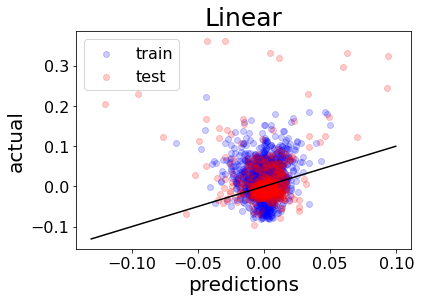

In [61]:
plt.scatter(train_labels,train_linear_preds, alpha=0.2, color='b',label='train')
plt.scatter(test_labels,test_linear_preds, alpha=0.2, color='r',label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.rcParams['font.size']='16'
# Set the axis labels and show the plot
plt.xlabel('predictions',fontsize = 20)
plt.ylabel('actual',fontsize = 20)
plt.title('Linear',fontsize = 25)
plt.legend()
plt.savefig('linear_scatter_compare.png',dpi=300)
plt.show()

In [17]:
df_spx = pd.read_csv('../s&p_return.csv')

In [18]:
df = pd.read_csv('linear_return.csv')
df = df.dropna()
df

,year,point,train_rmse,test_rmse
0,2011,72,0.041631,0.058222
1,2012,94,0.041631,0.058222
2,2013,121,0.041631,0.058222
3,2014,352,0.041631,0.058222
4,2015,262,0.041631,0.058222
5,2016,93,0.041631,0.058222
6,2017,275,0.041631,0.058222
7,2018,327,0.041631,0.058222
8,2019,41,0.041631,0.058222
9,2020,155,0.041631,0.058222


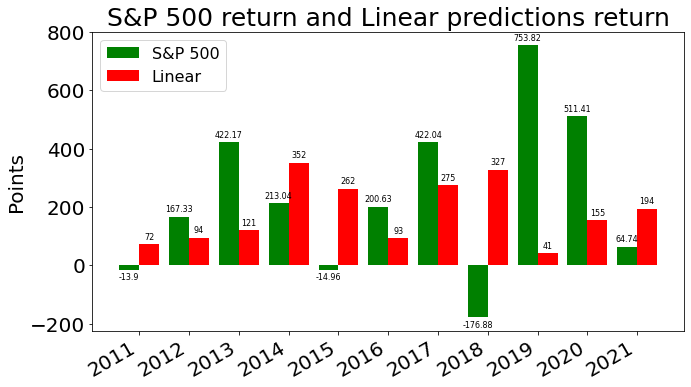

In [60]:
labels = ['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020','2021']
x = np.arange(len(df['year']))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2,df_spx['point'], width, label='S&P 500',color ='g')
rects2 = ax.bar(x + width/2,df['point'] , width, label='Linear', color = 'r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Points',fontsize = 20)
ax.set_title('S&P 500 return and Linear predictions return',fontsize = 25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=8 )
ax.bar_label(rects2, padding=3, fontsize=8 )

fig.tight_layout()
plt.rcParams['font.size']='16'
plt.legend(loc =2,prop={'size':16})
fig.autofmt_xdate()
plt.savefig('linear_return.png',dpi=300)
plt.show()

In [20]:
df_return.to_csv('df_return_linear.csv')

In [21]:
df_vs_features =['Date','close','predictions']
df_vs = df_return[df_vs_features]
df_vs.head(5)

,Date,close,predictions
0,2011-06-20,1278.36,0.080425
1,2011-06-21,1295.52,0.079623
2,2011-06-22,1287.14,0.054570
3,2011-06-23,1283.50,0.054820
4,2011-06-24,1268.45,0.048708


In [22]:
df_vs['pClose'] = df_vs['close']*(1+df_vs['predictions'])

<ipython-input-22-e78ad7227175>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df_vs.head(5)

,Date,close,predictions,pClose
0,2011-06-20,1278.36,0.080425,1381.172591
1,2011-06-21,1295.52,0.079623,1398.673014
2,2011-06-22,1287.14,0.054570,1357.379485
3,2011-06-23,1283.50,0.054820,1353.861548
4,2011-06-24,1268.45,0.048708,1330.233161


In [24]:
df_vs['pClose'] = df_vs['pClose'].shift(1)
df_vs.head(5)

<ipython-input-24-90c0fa3be022>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,close,predictions,pClose
0,2011-06-20,1278.36,0.080425,NaN
1,2011-06-21,1295.52,0.079623,1381.172591
2,2011-06-22,1287.14,0.054570,1398.673014
3,2011-06-23,1283.50,0.054820,1357.379485
4,2011-06-24,1268.45,0.048708,1353.861548


In [25]:
df_vs = df_vs.dropna()

In [26]:
df_vs

,Date,close,predictions,pClose
1,2011-06-21,1295.52,0.079623,1381.172591
2,2011-06-22,1287.14,0.054570,1398.673014
3,2011-06-23,1283.50,0.054820,1357.379485
4,2011-06-24,1268.45,0.048708,1353.861548
5,2011-06-27,1280.10,0.077088,1330.233161
...,...,...,...,...
2433,2021-02-19,3906.72,-0.020423,3807.537772
2434,2021-02-22,3876.51,-0.020392,3826.934707
2435,2021-02-23,3881.38,-0.005496,3797.460668
2436,2021-02-24,3925.44,0.000565,3860.046450


In [ ]:
#df_vs.to_csv('vs.csv')

In [56]:
def graphCompare(start_date,end_date):
    df_point_compare = df_vs.loc[df_vs['Date'].between(start_date,end_date,inclusive=False)]
    df_point_compare=df_point_compare.reset_index()
    #print(df_point_compare)
    fig = plt.figure(figsize=(20,6))
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='Real')
    plt.plot(df_point_compare['Date'],df_point_compare['pClose'],label='Prediction')
    #plt.xlabel('2011-2018')
    #plt.tick_params(axis='x',labelrotation=20)
    fig.autofmt_xdate()
    plt.ylabel('Points',fontsize = 20)
    plt.title('S&P 500 & Linear: '+start_date+'-'+end_date,fontsize = 25)
  #  plt.figure(figsize=(20,6))
    #plt.set_size_inches(10,5)
    plt.savefig('predict-'+start_date+'-'+end_date+'.png')
    plt.show()

No handles with labels found to put in legend.


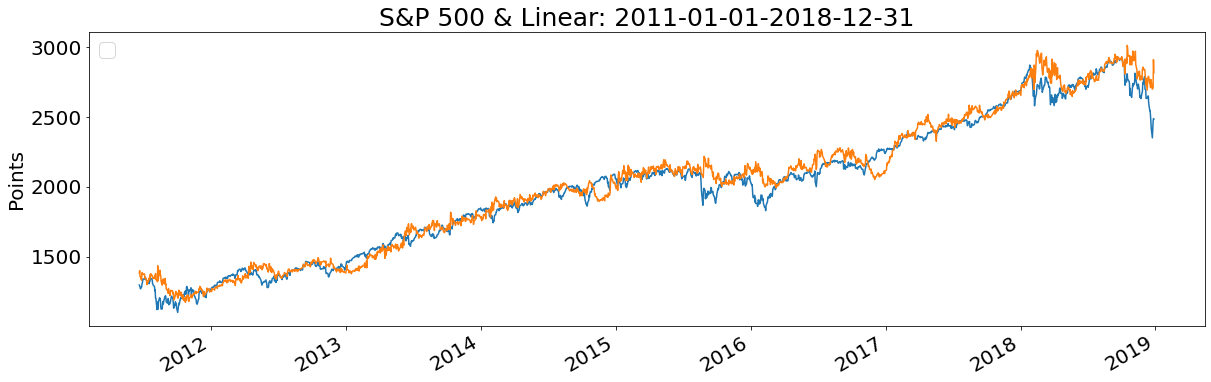

No handles with labels found to put in legend.


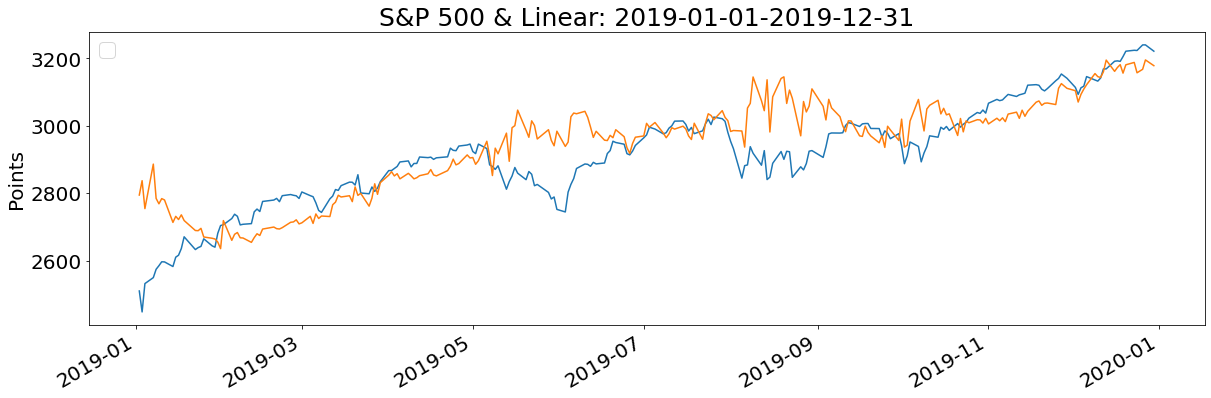

No handles with labels found to put in legend.


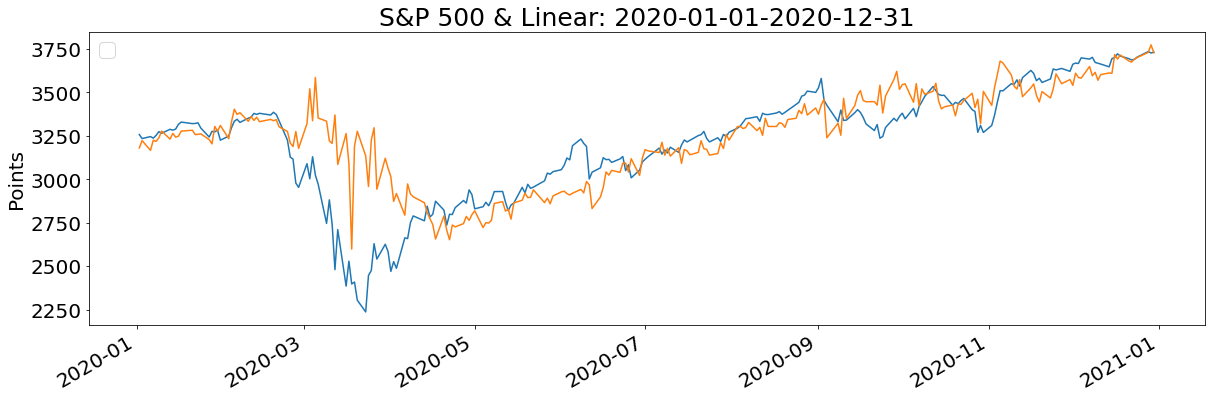

No handles with labels found to put in legend.


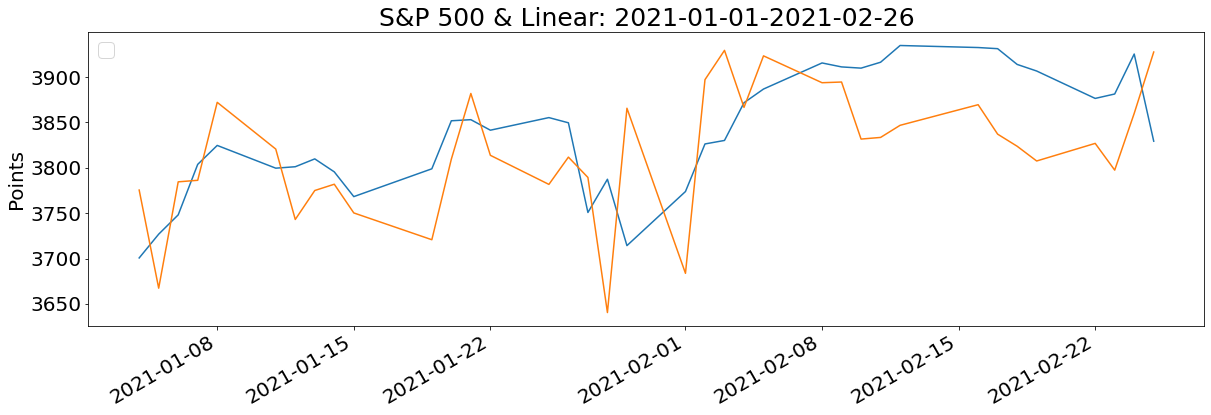

In [65]:
graphCompare("2011-01-01","2018-12-31")
graphCompare("2019-01-01","2019-12-31")
graphCompare("2020-01-01","2020-12-31")
graphCompare("2021-01-01","2021-02-26")

In [58]:
def showBuySell(start_date,end_date):
    df_point_compare = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    
   # df_point_compare = df_point_compare.reset_index()
 #   df_point_compare.head(10)
    fig = plt.figure(figsize=(20,6),dpi=300)
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='S&P 500')
    fig.autofmt_xdate()
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='buy' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='buy', 'close'].values, label='Buy', color='green', s=64, marker="^")
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='sell' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='sell', 'close'].values, label='Sell', color='red', s=64, marker="v")
    plt.ylabel('Points',fontsize = 20)
    plt.title('Linear buy and sell signal: '+start_date+'-'+end_date,fontsize = 25)

    plt.savefig('BuySell-'+start_date+'-'+end_date+'.png')

    #df_point_compare.to_csv('point_compare.csv')
    #plt.set_size_inches(10,5)
    plt.show()
    

No handles with labels found to put in legend.


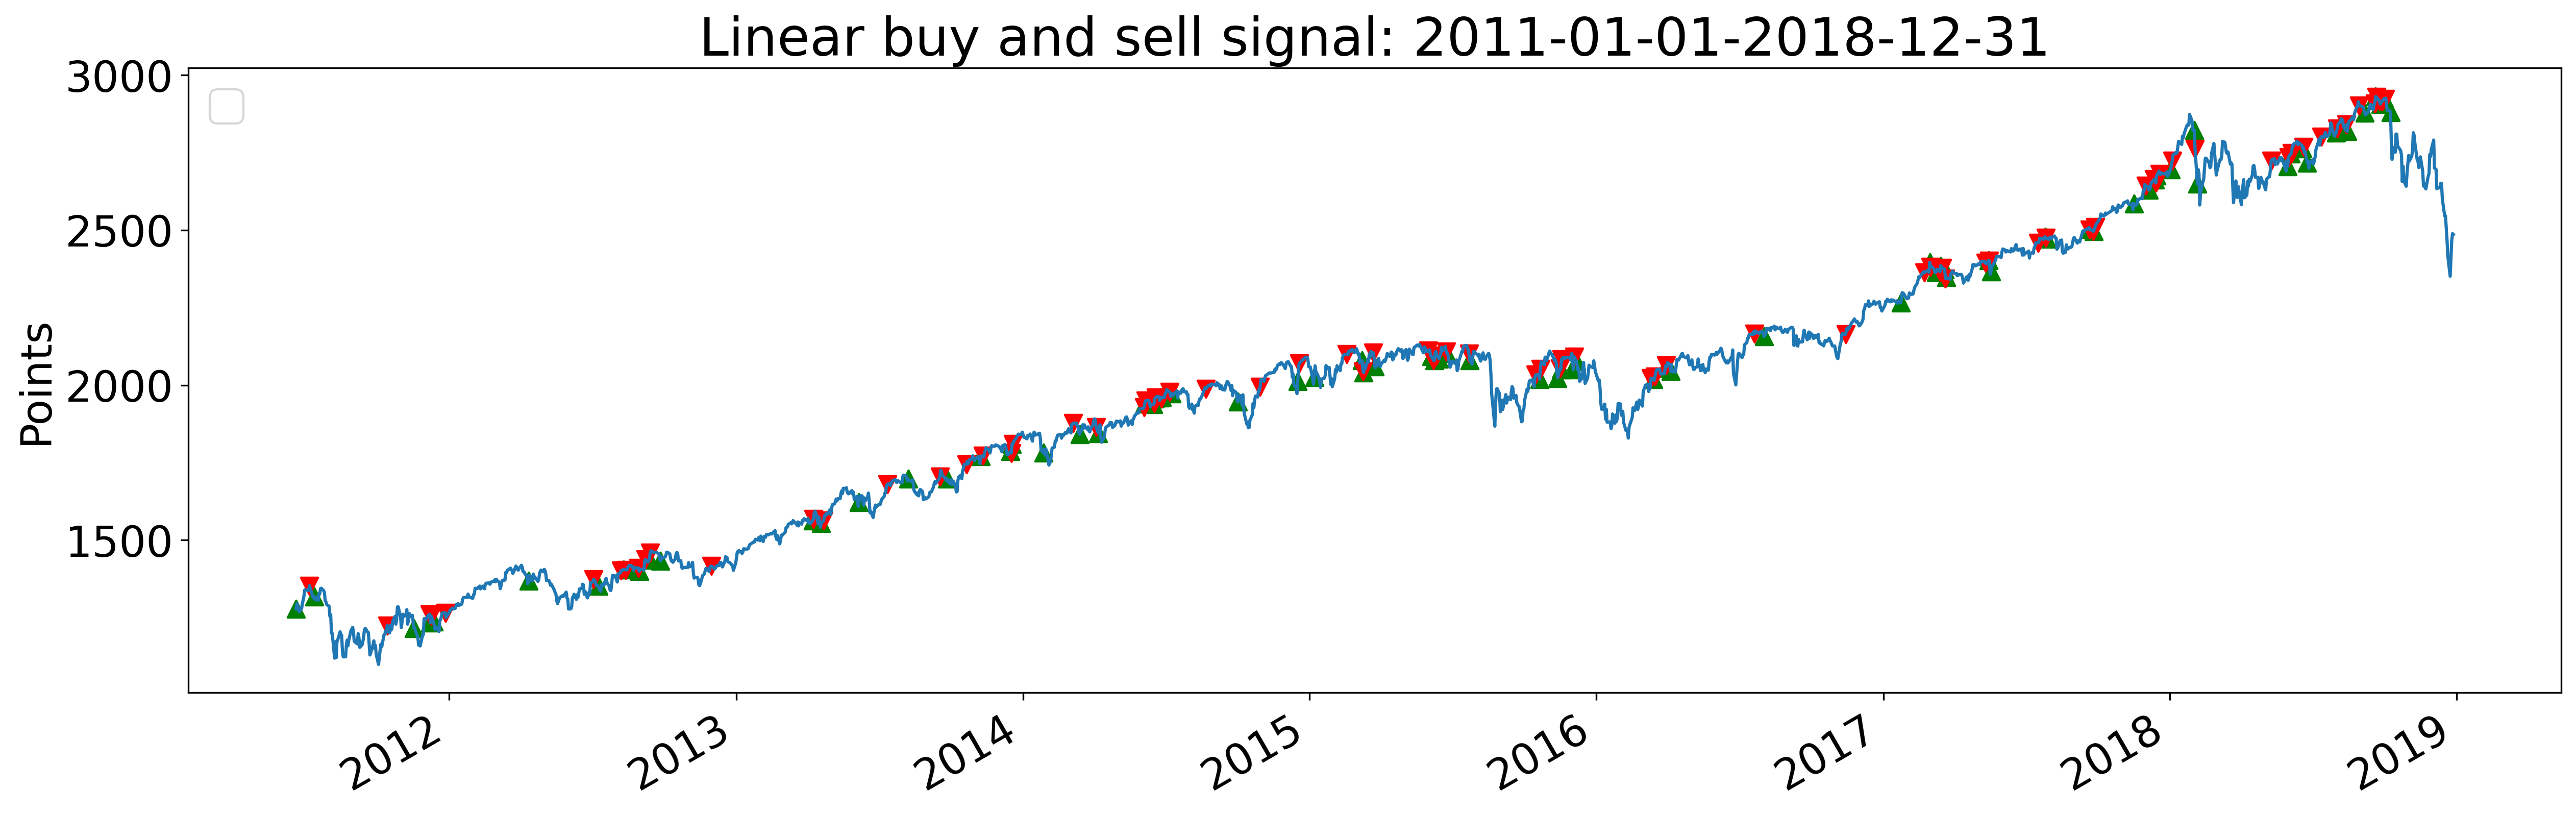

No handles with labels found to put in legend.


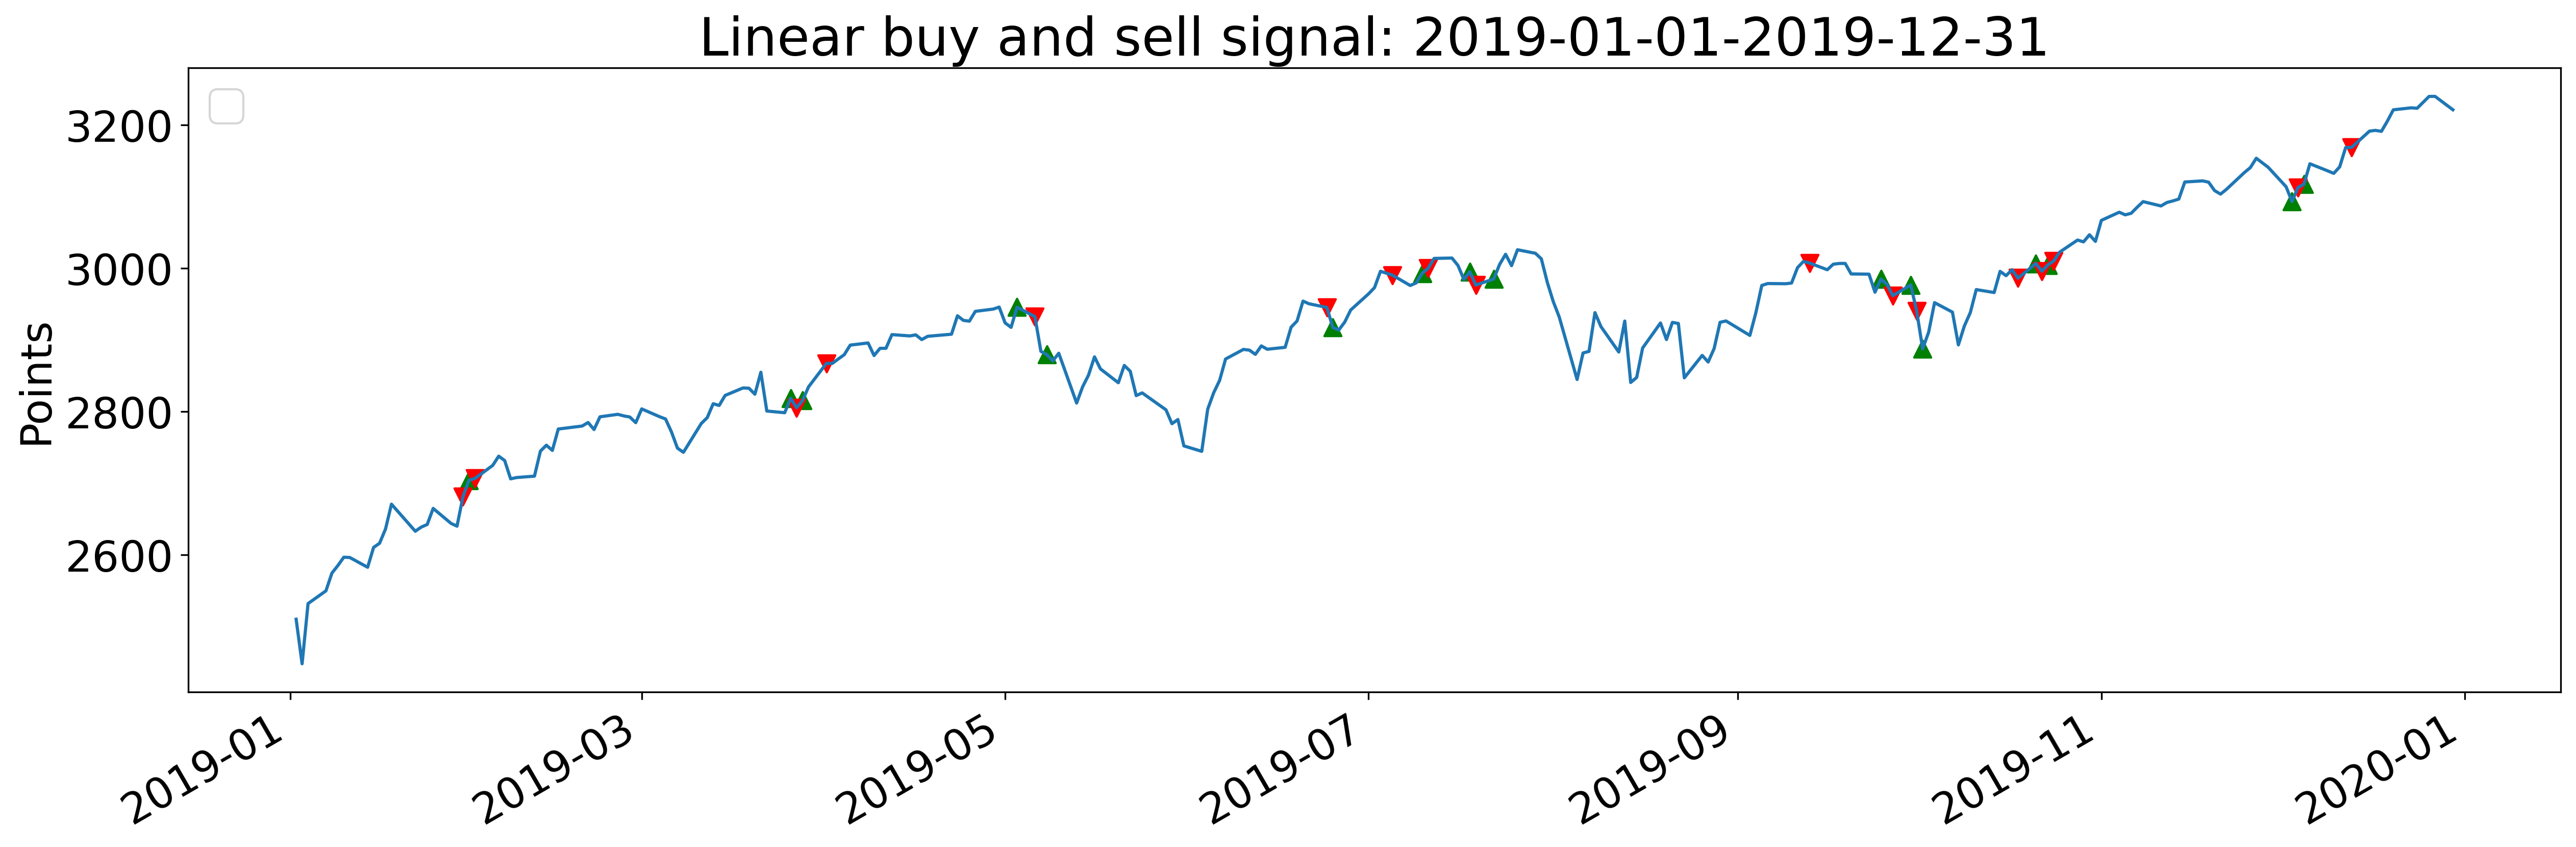

No handles with labels found to put in legend.


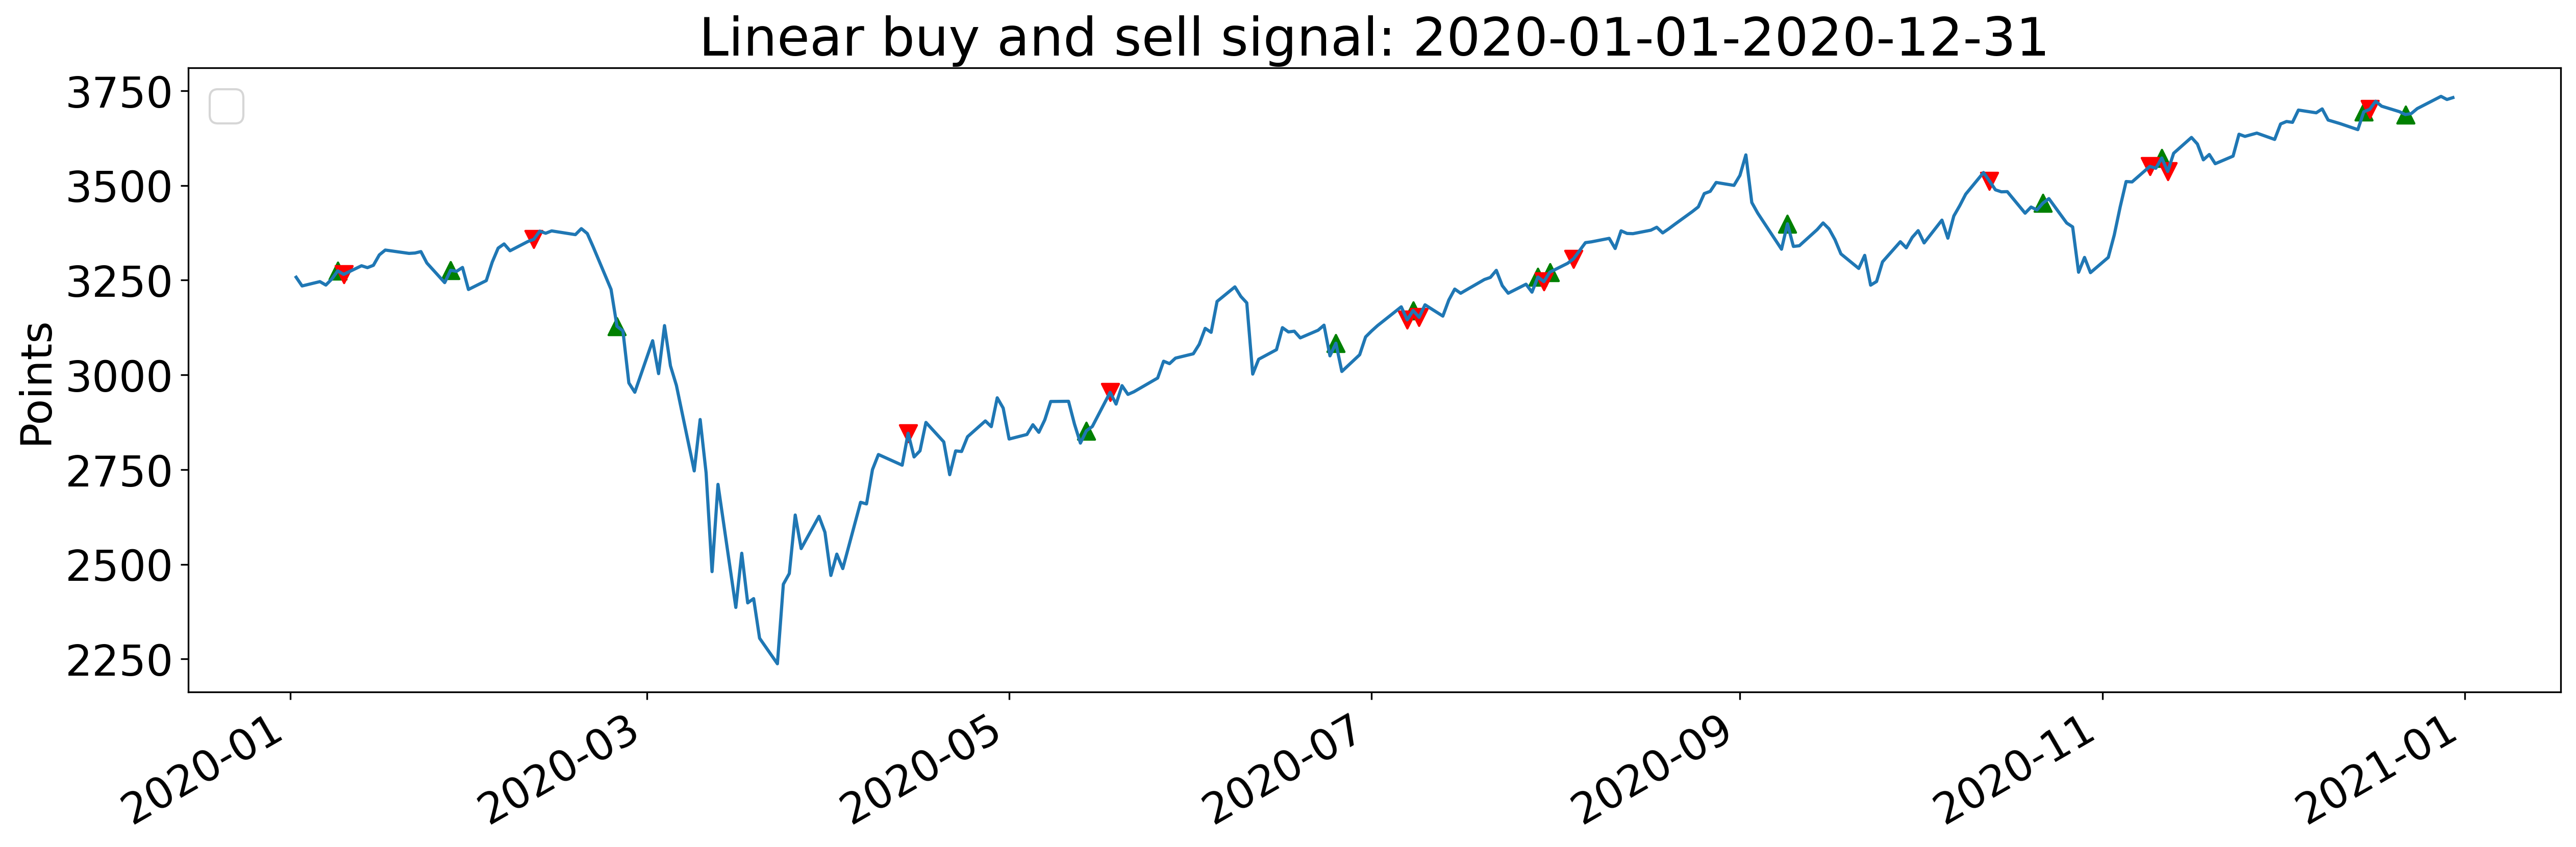

No handles with labels found to put in legend.


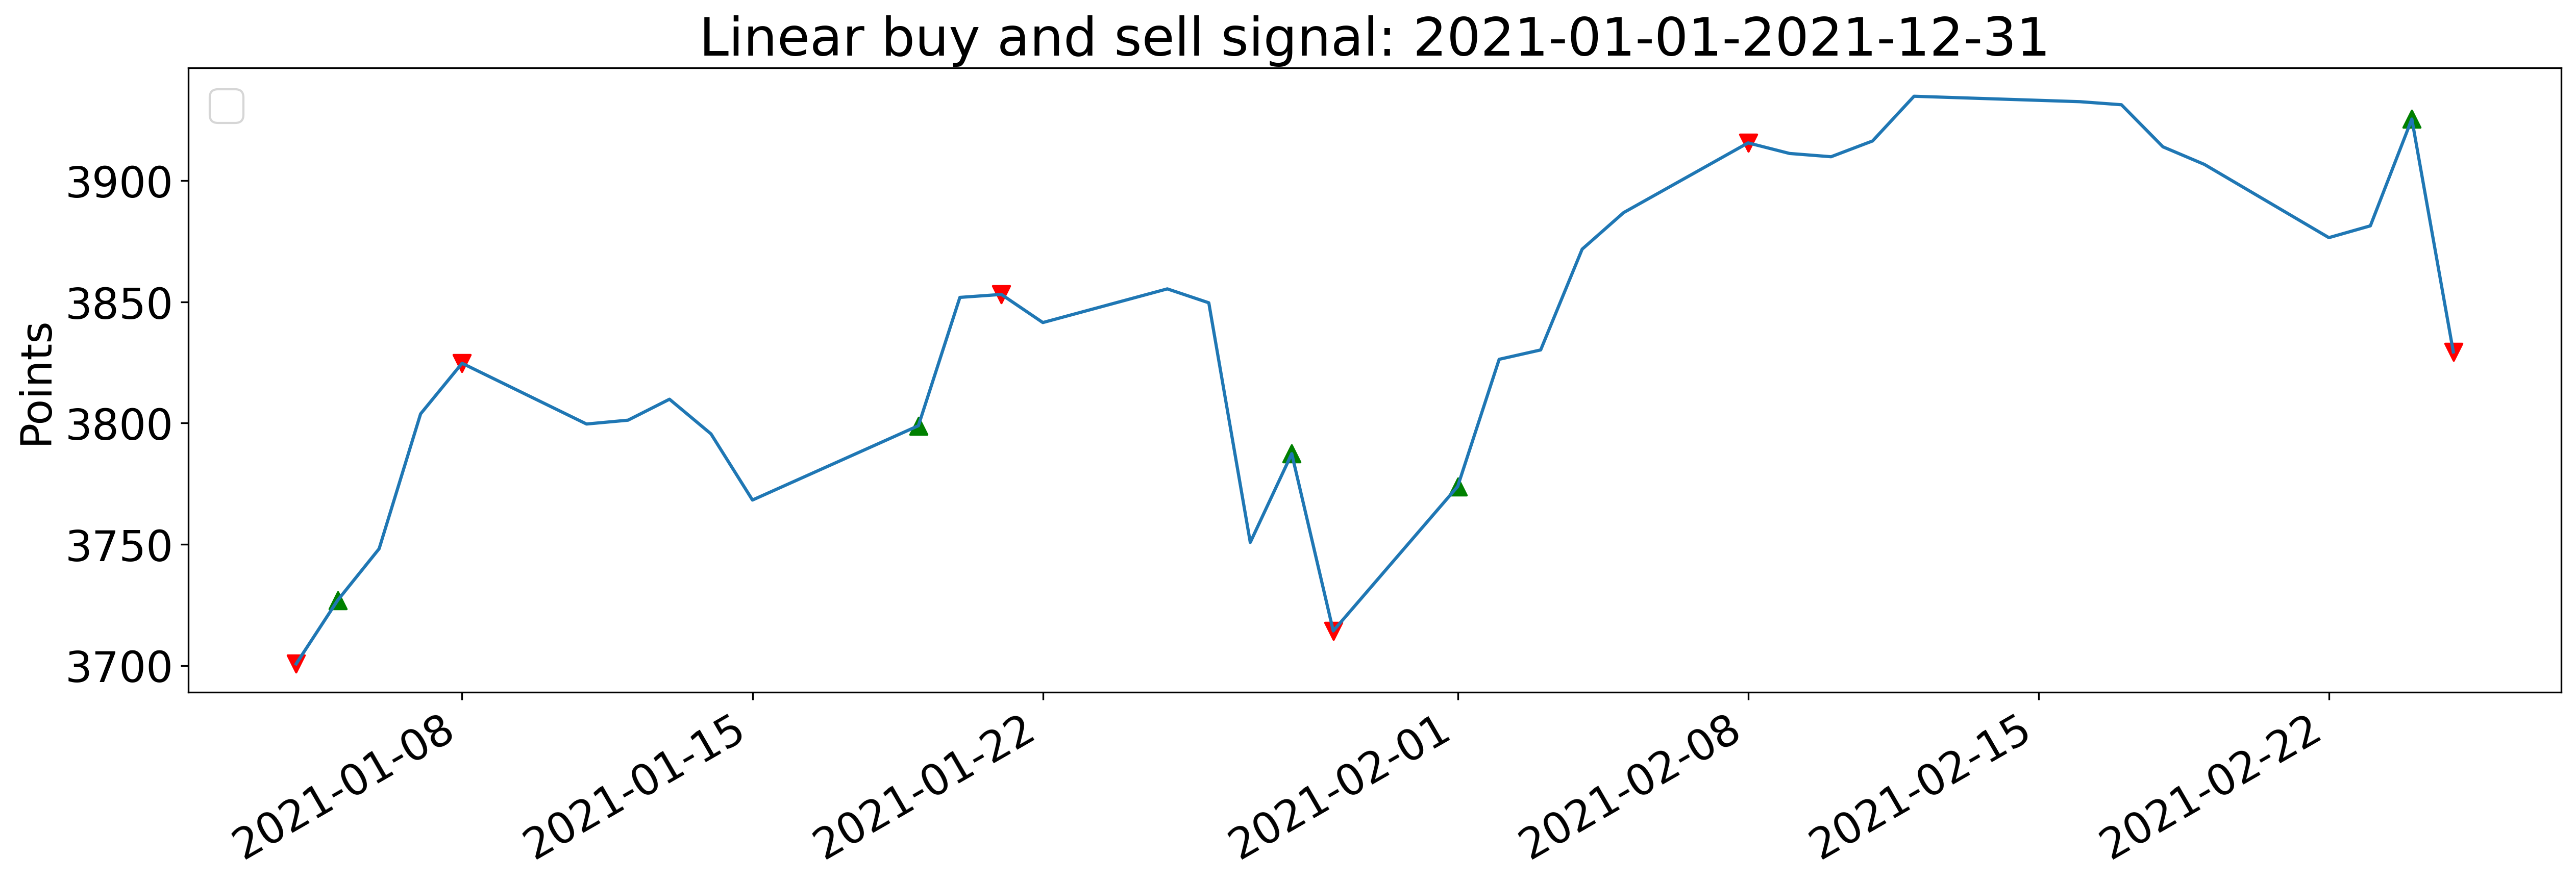

In [59]:
showBuySell("2011-01-01","2018-12-31")
showBuySell("2019-01-01","2019-12-31")
showBuySell("2020-01-01","2020-12-31")
showBuySell("2021-01-01","2021-12-31")